# Mixtec Gender Classification

### Imports

In [1]:
%matplotlib inline
# %pip install pandas numpy torcheval torch matplotlib
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torchvision import datasets, transforms

from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

torch.manual_seed(42)

### Define hardware

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}\n')
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda


NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Define path to images

In [3]:
basepath = Path('/home/christan/toorange/alexwebber/mixteclabeling') # Base data directory
path = basepath / 'data/labeled_figures/codex_vindobonensis/gender/'

### Load figures into dataset

In [4]:
## Load CSV
mixtec_figures = pd.read_csv(basepath / "data/mixtec_figures.csv")

print(mixtec_figures['gender'].value_counts())

## Define image transforms
## List of transforms https://pytorch.org/vision/stable/auto_examples/plot_transforms.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((227, 227), antialias=True),
     # transforms.Grayscale(),
     # transforms.ColorJitter(contrast=0.5),
     # transforms.RandomRotation(360),     # Maybe useful for standng and sitting
     # transforms.RandomHorizontalFlip(50),
     # transforms.RandomVerticalFlip(50)
])

## Load images into PyTorch dataset
figures_dataset = datasets.ImageFolder(path, transform=transform)

print(figures_dataset)

gender
male      429
female     45
Name: count, dtype: int64
Dataset ImageFolder
    Number of datapoints: 210
    Root location: /home/christan/toorange/alexwebber/mixteclabeling/data/labeled_figures/codex_vindobonensis/gender
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
           )


### Assign classes to map

In [5]:
class_map = {0: "female", 1: "male"}

### Print random image for sanity check

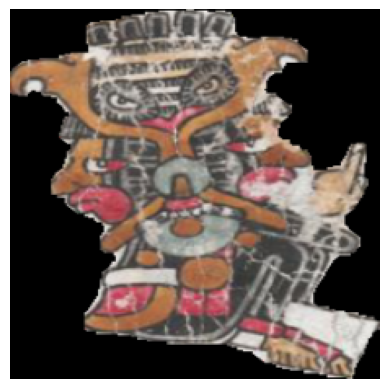

In [6]:
# Access a random image from the dataset
random_index = np.random.randint(len(figures_dataset))
image, label = figures_dataset[random_index]

# Convert the image tensor to a NumPy array and transpose it
image = image.permute(1, 2, 0)
image = image.numpy()

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

## Split datasets into training and testing sets

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def visualise_dataloader(dl, id_to_label=None, with_outputs=True):
    
    total_num_images = len(dl.dataset)
    idxs_seen = []
    class_0_batch_counts = []
    class_1_batch_counts = []
    
    
    for i, batch in enumerate(dl):
        
        idxs = batch[0][:, 0].tolist(); print(idxs)
        classes = batch[0][:, 1]
        class_ids, class_counts = classes.unique(return_counts=True)
        class_ids = set(class_ids.tolist())
        class_counts = class_counts.tolist()

        idxs_seen.extend(idxs)

        if len(class_ids) == 2:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(class_counts[1])
        elif len(class_ids) == 1 and 0 in class_ids:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(0)
        elif len(class_ids) == 1 and 1 in class_ids:
            class_0_batch_counts.append(0)
            class_1_batch_counts.append(class_counts[0])   
        else:
            raise ValueError('More than two classes detected')
            
    if with_outputs:
        
        fig, ax = plt.subplots(1, figsize=(15, 15))

        ind = np.arange(len(class_0_batch_counts))
        width = 0.35  
    
        ax.bar(ind, class_0_batch_counts, width, label=(id_to_label[0] if id_to_label is not None else '0'))
        ax.bar(ind + width, class_1_batch_counts, width, label=(id_to_label[1] if id_to_label is not None else '1'))
        ax.set_xticks(ind, ind+1)
        ax.set_xlabel('Batch index', fontsize=12)
        ax.set_ylabel('No. of images in batch', fontsize=12)
        ax.set_aspect('equal')
    
        plt.legend()
        plt.show()
        
        num_images_seen = len(idxs_seen)
        
        print(f'Avg Proportion of {(id_to_label[0] if id_to_label is not None else "Class 0")} per batch: {(np.array(class_0_batch_counts)/10).mean()}')
        print(f'Avg Proportion of {(id_to_label[1] if id_to_label is not None else "Class 1")} per batch: {(np.array(class_1_batch_counts)/10).mean()}')
        print('=============')
        print(f'Num. unique images seen: {len(set(idxs_seen))}/{total_num_images}')
    return class_0_batch_counts, class_1_batch_counts, idxs_seen

In [8]:
batch_size = 20

train_set, test_set = random_split(figures_dataset, [0.8, 0.2])

# FIXME
# class_counts = mixtec_figures.gender.value_counts()
# class_weights = 1/class_counts
# sample_weights = [1/class_counts[i] for i in mixtec_figures.gender.values]
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights=sample_weights, num_samples=batch_size, replacement=True)

# train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = False, sampler=sampler)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)

In [9]:
# FIXME
# class_0_batch_counts, class_1_batch_counts, idxs_seen = visualise_dataloader(train_set, 
                                                                             # {0: "Woman (Minority class)",
                                                                             #  1: "Man (Majority class)"})

In [10]:
# train_set.dataset

# Training

### Define CNN

In [11]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(16 * 56 * 56, 1568)  # Adjusted size

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 16 * 56 * 56)
        x = self.fc1(x)
        x = x.view(batch_size, -1)
        return x


# Create the model
cnn = CNN()
cnn.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
)

### Define hyperparameters

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

### Train model

In [13]:
cnn.train()
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()

        outputs = cnn(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % batch_size == 0:
            print("Epoch: " + str(epoch + 1) + " | " "Loss: " + str(running_loss))
        
            running_loss = 0.0

print('Finished Training')


Epoch: 1 | Loss: 8.027143478393555
Epoch: 2 | Loss: 1.4810185432434082
Epoch: 3 | Loss: 0.3958171010017395
Epoch: 4 | Loss: 0.278033971786499
Epoch: 5 | Loss: 0.6342433094978333
Epoch: 6 | Loss: 0.614977240562439
Epoch: 7 | Loss: 0.5339080095291138
Epoch: 8 | Loss: 0.3528648614883423
Epoch: 9 | Loss: 0.2322251796722412
Epoch: 10 | Loss: 0.4417371153831482
Epoch: 11 | Loss: 0.1508033722639084
Epoch: 12 | Loss: 0.3921698331832886
Epoch: 13 | Loss: 0.5387343168258667
Epoch: 14 | Loss: 0.042838260531425476
Epoch: 15 | Loss: 0.29068252444267273
Epoch: 16 | Loss: 0.18941844999790192
Epoch: 17 | Loss: 0.29580003023147583
Epoch: 18 | Loss: 0.3227729797363281
Epoch: 19 | Loss: 0.23747071623802185
Epoch: 20 | Loss: 0.11597170680761337
Epoch: 21 | Loss: 0.25178366899490356
Epoch: 22 | Loss: 0.14569047093391418
Epoch: 23 | Loss: 0.09810062497854233
Epoch: 24 | Loss: 0.20132581889629364
Epoch: 25 | Loss: 0.12170437723398209
Epoch: 26 | Loss: 0.057312898337841034
Epoch: 27 | Loss: 0.0145976394414901

### View incorrectly labeled samples

In [14]:
cnn.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
)

In [15]:
for i, data in enumerate(train_loader, 0):
    images, labels = data[0].to(device), data[1].to(device)
    
    outputs = cnn(images)
    
    _, predictions = torch.max(outputs, 1)
    
    correct = 0
    total = len(predictions)
    for label, image, prediction in zip(labels, images, predictions):
        if label != prediction:
            image = image.permute(1, 2, 0)
            image = image.cpu().numpy()

            plt.imshow(image)
            plt.title("Prediction: " + class_map[prediction.item()] + " | Label: " + class_map[label.item()])
            plt.axis('off')
            plt.show()


            

### Save model

In [16]:
savepath = "../models/mixtec_gender_classifier.pth"

torch.save(cnn.state_dict(), savepath)

### Visualize learning

In [17]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/mixtec_experiment_gender')

### Define tensorboard output function

In [18]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize1
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="gray")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

### Output sample heatmap of selected features

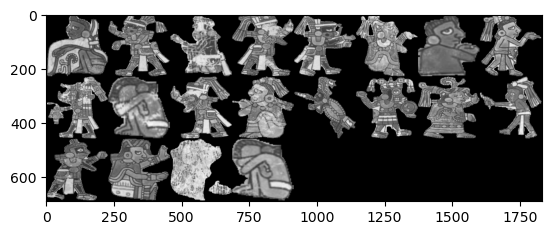

In [19]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('mixtec_genders', img_grid)

# Testing

### Load images and labels from test_loader

In [20]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

### Load model

In [21]:
cnn = CNN()
cnn.load_state_dict(torch.load(savepath))
cnn.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
)

### Produce predictions and calculate accuracy of model

In [22]:
cnn.eval()

predicted_list = []
target_list = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        target_list += labels.cpu()
        
        # calculate outputs by running images through the network
        outputs = cnn(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        print(_)
        predicted_list += predicted
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {str(len(test_set))} test images: {100 * correct // total} %')

tensor([50.3169, 51.6565, 53.7425, 45.6808, 49.0859, 48.6273, 42.5043, 53.2935,
        51.6520, 47.6878, 49.9207, 46.4069, 45.0123, 61.2005, 47.4151, 49.9650,
        55.2310, 40.0526, 46.2557, 43.2011], device='cuda:0')
tensor([45.2768, 50.9151, 51.8264, 52.9334, 47.9744, 47.8662, 45.3439, 50.6552,
        53.7150, 54.3404, 57.5762, 54.6029, 49.8128, 53.8627, 46.2226, 50.4685,
        51.8505, 39.9459, 50.4314, 48.1890], device='cuda:0')
tensor([53.0045, 46.8269], device='cuda:0')
Accuracy of the network on the 42 test images: 73 %


In [23]:
print(f"Predicted: {torch.tensor(predicted_list)}")
print(f"Truth    : {torch.tensor(target_list)}")

metric_names = ["Accuracy", "Precision", "Recall", "F1"]
metrics = [BinaryAccuracy(), BinaryPrecision(), BinaryRecall(), BinaryF1Score()]

for metric, name in zip(metrics, metric_names):
    metric.update(torch.tensor(predicted_list), torch.tensor(target_list))
    print(f"{name:<9}: {metric.compute()}")

Predicted: tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Truth    : tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1])
Accuracy : 0.738095223903656
Precision: 0.7567567825317383
Recall   : 0.9333333373069763
F1       : 0.8358209133148193
